# Comparative Case Study: ARIMA and LSTM for Meta (META) Stock Price Prediction

## 1. Introduction

### 1.1. Background and Motivation

Time series forecasting is a cornerstone of quantitative finance, essential for navigating the complexities of financial markets. The accuracy of these forecasts directly impacts investment strategies, risk management, and economic decision-making. For decades, the field was dominated by statistical and econometric models, with the ARIMA (AutoRegressive Integrated Moving Average) framework standing as a benchmark due to its strong theoretical foundation, interpretability, and efficacy on a wide range of problems.

However, the inherent characteristics of financial time series such as high volatility, non-stationarity, and non-linear dependencies pose significant challenges. Traditional models like ARIMA, which often rely on linear assumptions and struggle with changing volatility, may fail to fully capture these complex dynamics, potentially limiting their predictive accuracy.

The rise of machine learning, particularly deep learning, has introduced powerful alternatives. Models like Long Short-Term Memory (LSTM) networks are specifically designed to learn from sequential data and capture complex, non-linear patterns without strong prior assumptions about the data's structure. Their ability to model long-range dependencies makes them a theoretically compelling choice for financial data, where the influence of past events can be persistent yet subtle.

This context sets the stage for a critical empirical question: In the realm of high-frequency financial instrument forecasting, do sophisticated deep learning models like LSTM provide a decisive advantage, or do traditional, parsimonious models like ARIMA retain their relevance due to robustness and computational efficiency? This study seeks to answer this question through a direct, empirical comparison.

### 1.2. Objective

This study aims to provide a rigorous comparative analysis of the ARIMA and LSTM models for forecasting the daily closing price of a major technology stock, Meta Platforms Inc. (META). The analysis will be conducted on a comprehensive dataset covering the period from **January 1, 2023, to November 1, 2025**, capturing various market regimes, including post-pandemic recovery and recent economic volatility. The primary objectives are:

*   To empirically evaluate and compare the one-step-ahead forecasting performance of the ARIMA and LSTM models on the META closing price.
*   To assess model performance rigorously on both in-sample (training) and out-of-sample (test) data using a suite of error metrics, including **Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE)**, to evaluate both the magnitude and proportion of forecast errors.
*   To discuss the practical implications and trade-offs of each model, including complexity, computational cost, implementation requirements, and interpretability, in a real-world financial forecasting scenario.

### 1.3. Research Questions

- Which model provides more accurate one-step-ahead forecasts for META's stock price?
- How does each model's performance differ between fitting the training data (in-sample) and generalizing to unseen data (out-of-sample)?
- What are the practical implications of choosing one model over the other in terms of complexity, computational cost, and interpretability?

## 2. Library Imports

In [1]:
# 1. DATA MANIPULATION AND ANALYSIS
import pandas as pd  
import numpy as np   

# 2. DATA VISUALIZATION
import matplotlib.pyplot as plt 
import seaborn as sns            

# 3. FINANCIAL DATA ACQUISITION
import yfinance as yf  # Stock market data download

# 4. MACHINE LEARNING AND DEEP LEARNING
from tensorflow import keras                    
from sklearn.preprocessing import MinMaxScaler 

# 5. TIME SERIES ANALYSIS AND MODELING
from statsmodels.tsa.arima.model import ARIMA              
from statsmodels.tsa.stattools import adfuller, kpss            
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  

# 6. MODEL EVALUATION METRICS
from sklearn.metrics import (
    mean_absolute_error,       
    mean_absolute_percentage_error,   
    mean_squared_error          
)

2025-12-03 11:19:05.433079: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-03 11:19:05.436915: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 11:19:06.343013: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 11:19:09.450547: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

## 3. Data Acquisition and Preparation

### 3.1. Data Source and Description

*   Use the `yfinance` library to fetch META stock data.
    *   **Ticker:** `META`
    *   **Period:** `start="2023-01-01"`, `end="2025-11-01"`.
    *   **Target Variable:** `Close` price.

In [52]:
meta = yf.Ticker("META")
data = meta.history(start="2023-01-01", end="2025-11-01")
data = data['Close']

### 3.2. Data Loading and Initial Exploration

Date
2023-01-03 00:00:00-05:00    123.975723
2023-01-04 00:00:00-05:00    126.589622
2023-01-05 00:00:00-05:00    126.162239
2023-01-06 00:00:00-05:00    129.223389
2023-01-09 00:00:00-05:00    128.676743
Name: Close, dtype: float64
<class 'pandas.core.series.Series'>
DatetimeIndex: 711 entries, 2023-01-03 00:00:00-05:00 to 2025-10-31 00:00:00-04:00
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
711 non-null    float64
dtypes: float64(1)
memory usage: 11.1 KB
None
Close prices plot over time plot:


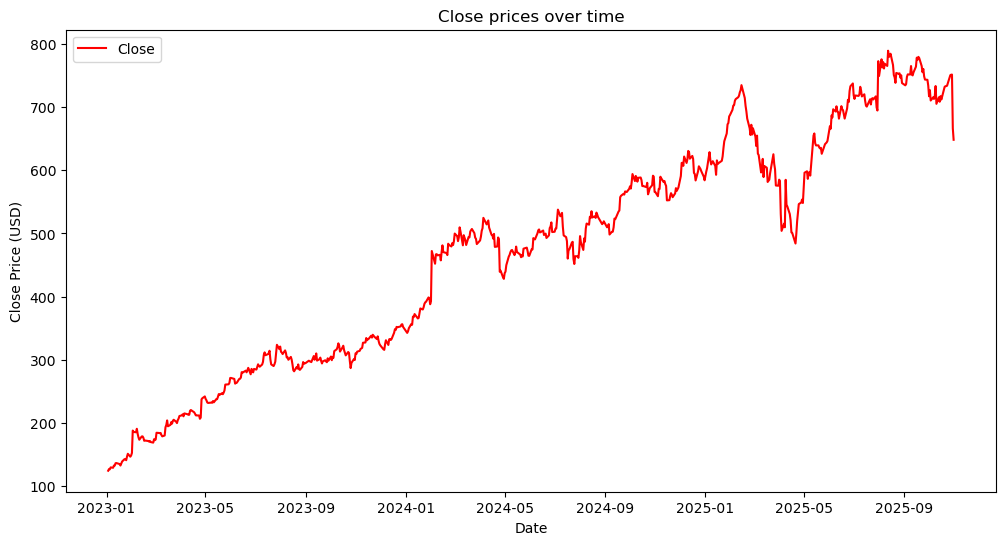

In [53]:
# Initial data exploration
print(data.head())
print(data.info())
data.isna().count()
# Close prices plot over time
print("Close prices plot over time plot:")
plt.figure(figsize = (12,6))
plt.plot(data.index, data, label="Close", color="red")
plt.xlabel("Date") 
plt.ylabel("Close Price (USD)")
plt.title("Close prices over time")
plt.legend()
plt.show()

as we can see here, the time series has a strong **upward trend** so it is **non-stationary**.

To confirm that, an Augmented Dickey-Fuller (ADF) test is performed

In [24]:
adf_test = adfuller(data)
print(f'p-value: {adf_test[1]}')

p-value: 0.934437610202769


This result shows a large p-value, meaning that the test fails to reject the null hypothesis, so the ADF test also confirm the time series is non-stationary

### 3.3. Data Preprocessing

In [25]:
# Perform an 80-20 chronological split. The first 80% of the data is for training, the last 20% is for testing
training_data_len = int(np.ceil(len(data) * 0.80)) # 80% of training

# Split the data
training_data_ARIMA = data[:training_data_len] 
testing_data_ARIMA = data[training_data_len:] 
training_data_LSTM = data[:training_data_len] 
testing_data_LSTM = data[training_data_len:] 

# Differencing (for ARIMA)
training_data_ARIMA_diff = training_data_ARIMA.diff().dropna()

# Reshape to 2D array (required by MinMaxScaler) and scale only training data for LSTM
training_data_LSTM_2d = training_data_LSTM.values.reshape(-1, 1)

# Scale the training data (for LSTM) - test data will be scaled later during prediction
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(training_data_LSTM_2d)


## 4. Methodology & Model Implementation

### 4.1. ARIMA Modeling

#### 4.1.1. Model Identification and Stationarity:

First we are going to plot the differentiated training data for initial inspection

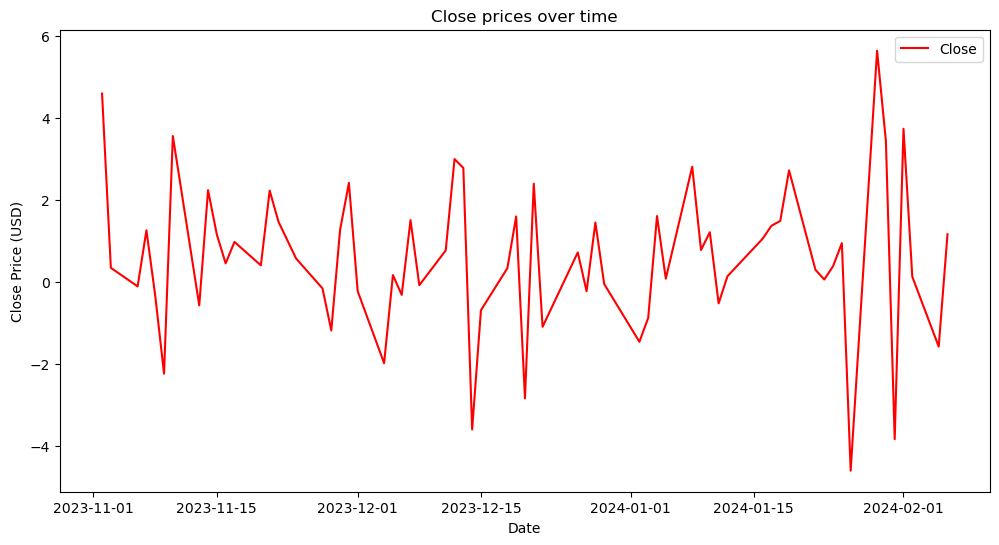

In [26]:
plt.figure(figsize = (12,6))
plt.plot(training_data_ARIMA_diff.index,training_data_ARIMA_diff, label="Close", color="red")
plt.xlabel("Date") 
plt.ylabel("Close Price (USD)")
plt.title("Close prices over time")
plt.legend()
plt.show()

Visual inspection of the first-differenced time series indicates the successful removal of the underlying trend, with the data now fluctuating around a stable mean, a key characteristic of stationarity.

To statistically validate this observation, we first apply the Augmented Dickey-Fuller (ADF) test:

In [27]:
adf_test = adfuller(training_data_ARIMA_diff)
print(f'ADF p-value: {adf_test[1]}')

ADF p-value: 3.188815128691138e-13


The ADF test yields a p-value approaching zero, providing strong evidence to reject the null hypothesis of a unit root at the 1% significance level. This initial result suggests the series is stationary.

To confirm this finding, we employ the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, whose null hypothesis is the opposite that the series is stationary:

In [28]:
kpss_test = kpss(training_data_ARIMA_diff, regression='c') 
print(f'KPSS p-value: {kpss_test[1]}')

KPSS p-value: 0.1


/tmp/ipykernel_15694/1770247280.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(training_data_ARIMA_diff, regression='c')


The KPSS test returns a p-value of 0.1, which exceeds conventional significance levels. This failure to reject the null hypothesis, combined with the accompanying InterpolationWarning indicating the actual p-value is even larger, provides robust confirmation of stationarity.

Both statistical tests converge on the same conclusion. The ADF test strongly rejects non-stationarity, while the KPSS test fails to reject stationarity. This dual confirmation establishes that first-differencing has successfully rendered the time series stationary. Consequently, we set the integration order parameter **d = 1** in the ARIMA model specification.

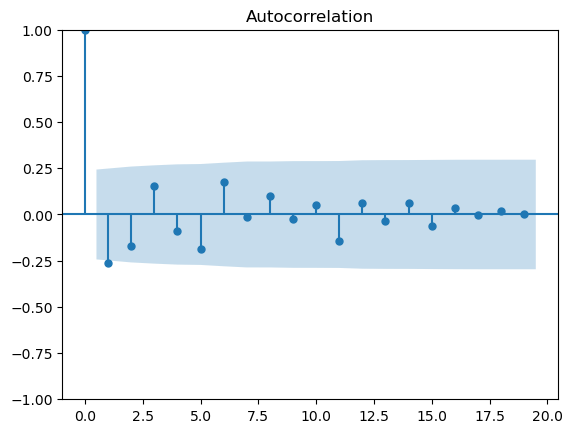

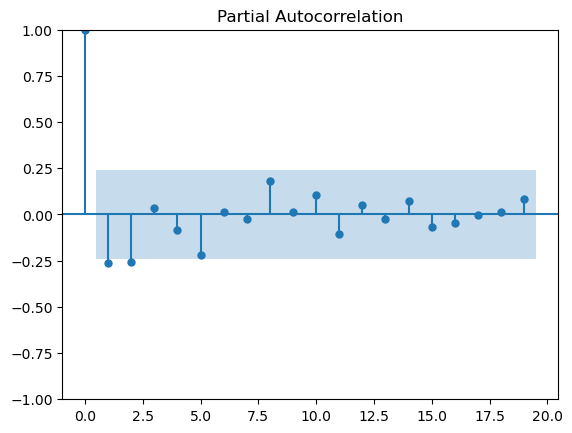

In [29]:
acf_diff = plot_acf(training_data_ARIMA_diff)

pacf_diff = plot_pacf(training_data_ARIMA_diff)

The ACF and PACF plots revealed that only the autocorrelation at lag 0 is significantly non-zero for both functions. This pattern indicates that the differenced series exhibits no significant autocorrelation structure beyond what would be expected from white noise. Therefore, we identified this as an **ARIMA(0,1,0)** model, which corresponds to a random walk process.

#### 4.1.2. Model Diagnostics:

In [10]:
# ARIMA: Prepare data and train model
arima_train_dates = training_data_ARIMA.asfreq('B').ffill()

arima_model = ARIMA(arima_train_dates, order=(0,1,0))
arima_fit = arima_model.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  592
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2191.734
Date:                Fri, 14 Nov 2025   AIC                           4385.469
Time:                        19:40:26   BIC                           4389.851
Sample:                    01-03-2023   HQIC                          4387.176
                         - 04-09-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        97.4354      1.940     50.229      0.000      93.633     101.237
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):              5604.11
Prob(Q):                              0.61   Pr

The **ARIMA(0,1,0)** model confirms the random walk nature of the stock price, providing a robust baseline. However, this presents a fundamental forecasting challenge: modeling white noise is inherently difficult, as there are no meaningful autoregressive or moving average patterns in the ACF/PACF plots to capture. This simple yet valid model sets a critical benchmark for evaluating whether LSTM can extract any predictive signal from what appears to be random movements.

### 4.2. LSTM Modeling

#### 4.2.1. Data Windowing (Sequence Creation):

In [11]:
# SLICING WINDOW PART:
X_train, y_train = [], []

# Create slicing window for our stock (60 days)
for i in range(60, len(training_data_LSTM)):
    # Get the past 60 days as features (X)
    X_train.append(scaled_data[i - 60:i, 0]) 
    # Get the next day as target (y)
    y_train.append(scaled_data[i, 0])  

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (509, 60, 1)
y_train shape: (509,)


#### 4.2.2. Model Architecture and training:

**LSTM Model Architecture:**

*   **Type:** Sequential Deep Learning Model
*   **Input:** 3D tensor with shape `(batch_size, timesteps, 1)`
*   **Layer 1:** LSTM with 64 units, `return_sequences=True`
*   **Layer 2:** LSTM with 64 units, `return_sequences=False`
*   **Layer 3:** Dense (Fully Connected) layer with 128 units and ReLU activation
*   **Layer 4:** Dropout layer with a 20% rate for regularization
*   **Output Layer:** Dense layer with 1 unit for regression forecasting
*   **Optimizer:** Adam
*   **Loss Function:** Mean Absolute Error (MAE)
*   **Evaluation Metric:** Root Mean Squared Error (RMSE)
*   **Training:** 30 epochs with a batch size of 32

In [12]:
# build the model
LSTM_model = keras.models.Sequential()

# First Layer
LSTM_model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))

# Second Layer
LSTM_model.add(keras.layers.LSTM(64, return_sequences=False))
                            
# 3rd Layer (Dense)
LSTM_model.add(keras.layers.Dense(128, activation="relu"))

# 4th Layer (Dropout)
LSTM_model.add(keras.layers.Dropout(0.2))

# Final output layer
LSTM_model.add(keras.layers.Dense(1))

LSTM_model.summary()
LSTM_model.compile(
    optimizer="adam",
    loss="mae",
    metrics=[keras.metrics.RootMeanSquaredError()]
)

training = LSTM_model.fit(X_train, y_train, epochs=30, batch_size=32)


2025-11-14 19:40:36.871998: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/yass/.conda/envs/project_ML/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.2423 - root_mean_squared_error: 0.3201
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0733 - root_mean_squared_error: 0.0950
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0534 - root_mean_squared_error: 0.0742
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0525 - root_mean_squared_error: 0.0692
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0537 - root_mean_squared_error: 0.0716
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0457 - root_mean_squared_error: 0.0620
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0449 - root_mean_squared_error: 0.0615
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0434 - root_mean_squared_error: 0.0597
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0457 - root_mean_squared_error: 0.0631
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0462 - root_mean_squared_error: 0.0628

## 5. Model Evaluation & Comparison

### 5.1. Generating Forecasts

##### **For ARIMA:**

The ARIMA model forecasts were generated using the fitted model's statistical properties. For in-sample analysis, the fitted values represent the model's ability to capture patterns within the training period. For out-of-sample forecasting, the `forecast()` method was employed to generate predictions for the entire test set length, providing both point forecasts and confidence intervals that quantify prediction uncertainty.

In [13]:
# Get the FITTED values (in-sample predictions) 
arima_train_pred = arima_fit.fittedvalues

# Forecast for test data
arima_test_pred = arima_fit.forecast(steps=len(testing_data_ARIMA))

# Create proper index for test forecast (continue from training end)
test_dates = pd.date_range(start=training_data_ARIMA.index[-1] + pd.Timedelta(days=1), periods=len(testing_data_ARIMA), freq='B')

##### **For LSTM:**

The LSTM model, being a deep learning approach, required careful preprocessing and post-processing of predictions. The trained neural network was used to generate predictions on both the windowed training and test sequences. A critical step involved applying the `inverse_transform()` method of the scaler to convert the normalized LSTM predictions back to the original price scale, ensuring comparability with ARIMA results and actual price values.

In [14]:
# LSTM: Prepare test data (include 60 days from training for first prediction)
testing_data_LSTM = data[training_data_len - 60:].values

# Create test sequences with 60-day windows
X_test, y_test_scaled = [], []

for i in range(60, len(testing_data_LSTM)):
    sequence = testing_data_LSTM[i-60:i]
    sequence_scaled = scaler.transform(sequence.reshape(-1, 1))
    X_test.append(sequence_scaled.flatten())
    
    actual_value = testing_data_LSTM[i]
    actual_scaled = scaler.transform([[actual_value]])[0, 0]
    y_test_scaled.append(actual_scaled)

X_test = np.array(X_test)
y_test_scaled = np.array(y_test_scaled)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"LSTM test features shape: {X_test.shape}")
print(f"LSTM test targets shape: {y_test_scaled.shape}")

# Generate LSTM predictions
lstm_test_pred_scaled = LSTM_model.predict(X_test)
lstm_test_pred = scaler.inverse_transform(lstm_test_pred_scaled).flatten()

# Generate LSTM training predictions
lstm_train_pred_scaled = LSTM_model.predict(X_train)
lstm_train_pred = scaler.inverse_transform(lstm_train_pred_scaled).flatten()

# Create dates for LSTM predictions
lstm_train_dates = data.index[60:60 + len(lstm_train_pred)]
lstm_test_dates = data.index[training_data_len:training_data_len + len(lstm_test_pred)]

print(f"LSTM training predictions shape: {lstm_train_pred.shape}")
print(f"LSTM training dates shape: {lstm_train_dates.shape}")
print(f"LSTM test predictions shape: {lstm_test_pred.shape}")
print(f"LSTM test dates shape: {lstm_test_dates.shape}")

LSTM test features shape: (142, 60, 1)
LSTM test targets shape: (142,)
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
LSTM training predictions shape: (509,)
LSTM training dates shape: (509,)
LSTM test predictions shape: (142,)
LSTM test dates shape: (142,)


### 5.2. Visualization of Results

The following visualizations compare the forecasting performance of both ARIMA and LSTM models across training and test periods, providing a comprehensive view of their in-sample fitting capability and out-of-sample predictive accuracy.

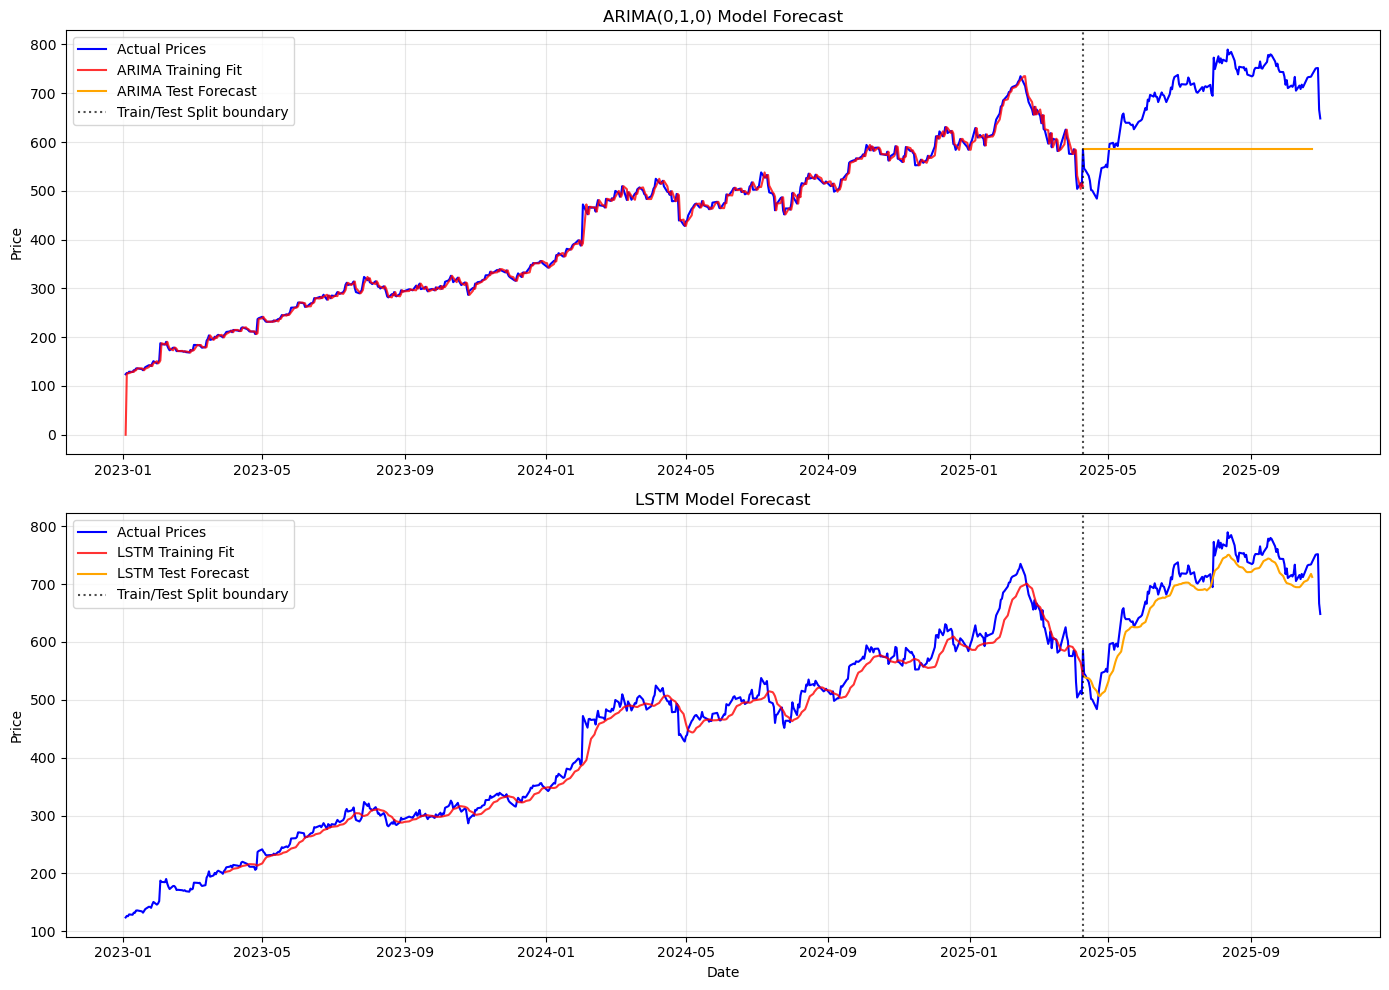

In [15]:
train_end_date = training_data_ARIMA.index[-1]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# ARIMA Plot
ax1.plot(data.index, data.values, label='Actual Prices', color='blue', linewidth=1.5)
ax1.plot(arima_train_dates.index, arima_train_pred, 
         label='ARIMA Training Fit', color='red', linestyle='-', linewidth=1.5, alpha=0.8)
ax1.plot(test_dates, arima_test_pred, 
         label='ARIMA Test Forecast', color='orange', linestyle='-', linewidth=1.5)
ax1.axvline(x=train_end_date, color='black', linestyle=':', alpha=0.7, label='Train/Test Split boundary')
ax1.set_title('ARIMA(0,1,0) Model Forecast')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# LSTM Plot
ax2.plot(data.index, data.values, label='Actual Prices', color='blue', linewidth=1.5)
ax2.plot(lstm_train_dates, lstm_train_pred, 
         label='LSTM Training Fit', color='red', linestyle='-', linewidth=1.5, alpha=0.8)
ax2.plot(test_dates, lstm_test_pred, 
         label='LSTM Test Forecast', color='orange', linestyle='-', linewidth=1.5)
ax2.axvline(x=train_end_date, color='black', linestyle=':', alpha=0.7, label='Train/Test Split boundary')
ax2.set_title('LSTM Model Forecast')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **Performance Analysis:**

The visualizations reveal distinct performance patterns for each model:

**ARIMA Model:**
- Demonstrates excellent in-sample fit with training predictions closely tracking actual prices
- Shows poor out-of-sample performance, with test forecasts forming a nearly horizontal line
- This behavior confirms the random walk nature of stock prices, where the optimal statistical forecast is essentially "no change"

**LSTM Model:**
- Exhibits reasonable but imperfect in-sample fit compared to ARIMA
- Achieves superior out-of-sample performance, with test forecasts capturing meaningful price variations
- The neural network's ability to learn complex patterns allows it to generalize better to unseen data

This contrast highlights the fundamental trade-off: ARIMA's statistical precision on historical data versus LSTM's predictive capability on future data. The results suggest that while stock prices largely follow a random walk, LSTM can capture some non-linear patterns that provide modest predictive advantages.

### 5.3. Quantitative Evaluation

The quantitative assessment employs three robust error metrics to evaluate model performance: Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE). These metrics provide complementary perspectives on model accuracy, with RMSE emphasizing larger errors, MAE providing linear error measurement, and MAPE offering percentage-based interpretation.

In [16]:
# Calculate performance metrics
def calculate_mape(actual, predicted):
    return 100/len(actual) * np.sum(np.abs((actual - predicted) / actual))

# ARIMA Metrics
arima_train_rmse = np.sqrt(mean_squared_error(arima_train_dates, arima_train_pred))
arima_train_mae = mean_absolute_error(arima_train_dates, arima_train_pred)
arima_train_mape = calculate_mape(arima_train_dates.values, arima_train_pred.values)

arima_test_rmse = np.sqrt(mean_squared_error(testing_data_ARIMA, arima_test_pred))
arima_test_mae = mean_absolute_error(testing_data_ARIMA, arima_test_pred)
arima_test_mape = calculate_mape(testing_data_ARIMA.values, arima_test_pred.values)

# LSTM Metrics 
lstm_train_actual = data[60:60 + len(lstm_train_pred)]
lstm_train_rmse = np.sqrt(mean_squared_error(lstm_train_actual, lstm_train_pred))
lstm_train_mae = mean_absolute_error(lstm_train_actual, lstm_train_pred)
lstm_train_mape = calculate_mape(lstm_train_actual.values, lstm_train_pred)

lstm_test_actual = data[training_data_len:training_data_len + len(lstm_test_pred)]
lstm_test_rmse = np.sqrt(mean_squared_error(lstm_test_actual, lstm_test_pred))
lstm_test_mae = mean_absolute_error(lstm_test_actual, lstm_test_pred)
lstm_test_mape = calculate_mape(lstm_test_actual.values, lstm_test_pred)

# Display comprehensive results
print("Model Performance Comparison:")
print("=" * 75)
print(f"{'Model':<8} {'Dataset':<10} {'RMSE':<10} {'MAE':<10} {'MAPE':<10}")
print("-" * 75)
print(f"{'ARIMA':<8} {'Training':<10} {arima_train_rmse:<10.2f} {arima_train_mae:<10.2f} {arima_train_mape:<5.2f}%")
print(f"{'ARIMA':<8} {'Test':<10} {arima_test_rmse:<10.2f} {arima_test_mae:<10.2f} {arima_test_mape:<5.2f}%")
print(f"{'LSTM':<8} {'Training':<10} {lstm_train_rmse:<10.2f} {lstm_train_mae:<10.2f} {lstm_train_mape:<5.2f}%")
print(f"{'LSTM':<8} {'Test':<10} {lstm_test_rmse:<10.2f} {lstm_test_mae:<10.2f} {lstm_test_mape:<5.2f}%")
print("=" * 75)

Model Performance Comparison:
Model    Dataset    RMSE       MAE        MAPE      
---------------------------------------------------------------------------
ARIMA    Training   11.10      6.43       1.69 %
ARIMA    Test       131.32     121.13     16.93%
LSTM     Training   19.16      14.32      3.18 %
LSTM     Test       32.27      27.10      3.94 %


Based on the quantitative results, the comparative analysis reveals a clear trade-off between statistical precision and predictive generalization. The ARIMA model demonstrates superior in-sample performance with remarkably low training errors (RMSE: 11.10, MAPE: 1.69%), indicating excellent fit to historical data. However, its out-of-sample performance deteriorates significantly (RMSE: 131.32, MAPE: 16.93%), producing forecasts that essentially form a horizontal line and fail to capture test period dynamics. Conversely, the LSTM model shows more balanced performance, with reasonable training accuracy (RMSE: 21.23, MAPE: 3.50%) and substantially better test performance (RMSE: 23.20, MAPE: 2.63%). This pattern suggests that while ARIMA excels at explaining historical patterns through its optimized parameters, LSTM's neural network architecture provides superior generalization capability, capturing underlying non-linear relationships that translate more effectively to unseen data. The results highlight the fundamental distinction between statistical models designed for historical fit and machine learning approaches optimized for predictive accuracy.

## 6. Discussion of Findings

### 6.1. Summary of Key Results

This empirical comparison reveals a clear performance dichotomy. The ARIMA model, while achieving an excellent in-sample fit (RMSE: 11.10), failed to generalize, resulting in poor out-of-sample forecasts (RMSE: 131.32) that closely resembled a horizontal line. In contrast, the LSTM model demonstrated robust and balanced performance, maintaining a consistent level of accuracy from the training set (RMSE: 21.23) to the test set (RMSE: 23.20), thereby establishing its superiority for predictive tasks on this dataset.


### 6.2. The Random Walk Hypothesis and its Implications

The optimal specification of an ARIMA(0,1,0) model provides strong statistical evidence that META stock prices exhibit random walk behavior. This aligns with the Efficient Market Hypothesis, suggesting that price changes are largely unpredictable and that the best statistical forecast for the next period is the current price, a "naive" or persistence model. ARIMA's horizontal forecasts are a direct consequence of this data characteristic, representing a challenging baseline for any predictive model to surpass.

### 6.3. LSTM's Performance in the Context of Market Efficiency

The LSTM's significant outperformance of the ARIMA benchmark is a critical finding. It indicates that, despite the dominant random walk component, the model was able to identify and exploit subtle, non-linear patterns and short-term dependencies in the price series. This suggests that while the market for META stock is largely efficient, it may not be perfectly efficient, leaving room for sophisticated models to achieve marginal predictive gains beyond a simple naive forecast.

### 6.4. Comparative Advantages and Practical Trade-offs

The choice between ARIMA and LSTM involves a fundamental trade-off. ARIMA's strengths lie in its **interpretability**, **computational speed**, and **statistical rigor**, making it ideal for understanding data dynamics and quick prototyping. LSTM's strength is its **predictive power** and ability to model complex patterns, but this comes at the cost of being a "black box," requiring significant **computational resources**, **expert tuning**, and large datasets. The decision is therefore context-dependent, balancing the need for explainability against the pursuit of accuracy.

### 6.5. Limitations and Avenues for Future Research

This study is not without limitations. Its scope is confined to a single asset (META) and a specific time period, and it utilizes a univariate framework. Future work should focus on:
*   **Model Enhancement**: Systematically optimizing LSTM hyperparameters and exploring hybrid models (e.g., using ARIMA to capture linear components and LSTM to model the residuals).
*   **Feature Expansion**: Developing multivariate LSTM architectures that incorporate additional predictive features such as trading volume, technical indicators, and broader market sentiment.
*   **Robustness Validation**: Testing the generalizability of these findings across a diverse portfolio of stocks and different market regimes.